In [1]:
import sklearn as sk
import tensorflow as tf
from tensorflow import keras
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
#Generating a series
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1)*(freq1 * 10 + 10)) #first wave
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) #add another wave
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) #putting in some noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
#For plotting time series
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize = 10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth = 1)
    plt.axis([0, n_steps+1, -1, 1])

In [4]:
#For plotting learning curves
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training Loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label = "Validation Loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.1])
    plt.legend(fontsize = 14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [5]:
np.random.seed(69)
n_steps = 60
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000: ,-1]

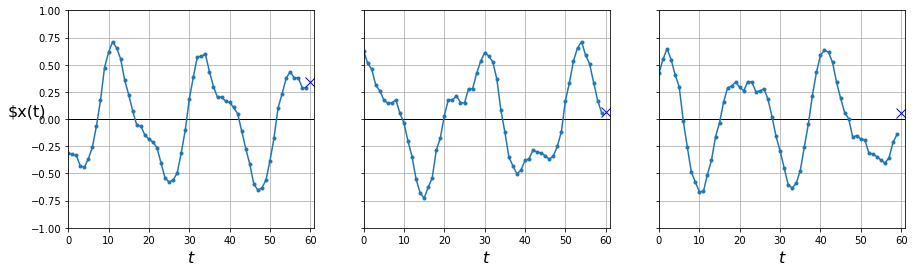

In [6]:
#let's just look at a few of these
fig, axes = plt.subplots(nrows = 1, ncols = 3, sharey = True, figsize=(15,4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=("$x(t)" if col==0 else None))
plt.show()

In [7]:
#Make some linear predictions as a baseline.

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[60, 1]),
    keras.layers.Dense(1)
])

model.compile(loss = "mse", optimizer = "adam")
history = model.fit(X_train, y_train, epochs = 20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0410
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0183
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0141 - val_loss: 0.0112
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0087
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0074
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0047

In [8]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0035


0.0034632356837391853

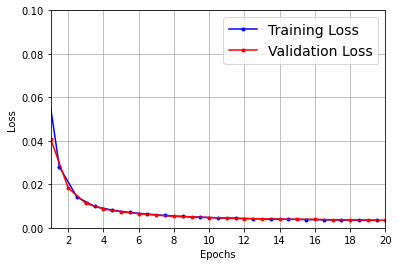

In [9]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

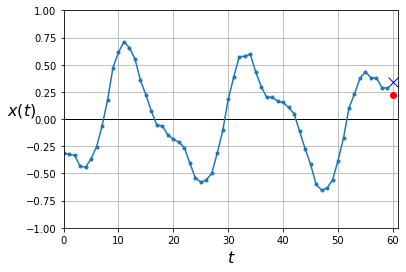

In [10]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :,0], y_valid[0, 0], y_pred[0, 0])
plt.show()

<h4>Simple RNN</h4>
<p>Using the univariate time series generated above, I'll use a variety of different RNN architectures to try and predict the future points of the sequence, and do so better than the simple RNN and the linear model. The first go will be using a sequence to vector RNN with just one recurrent layer with one neuron. For all of these the I'll use Mean Squared Error (mse) loss and an adaptive moment estimation (adam) optimizer. The adam optimizer keeps track of an exponentially decaying average of past gradients and past squared gradients (like momentum optimization and RMSProp combined), and speeds up training very well for RNNs.  </p>

In [11]:
#Using a simple RNN
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model.compile(loss = "mse", optimizer = keras.optimizers.Adam(lr=0.005))
history = model.fit(X_train, y_train, epochs = 20, validation_data = (X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0296 - val_loss: 0.0101
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0094 - val_loss: 0.0090
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 7/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 8/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 9/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0091 - val_loss: 0.0089
Epoch 10/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0091 - val_loss: 0.0089

In [12]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0089


0.008857715874910355

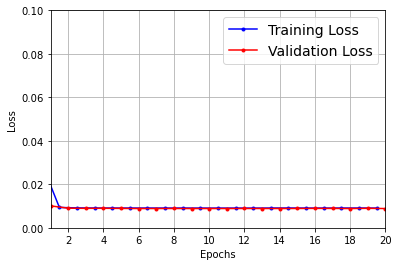

In [13]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

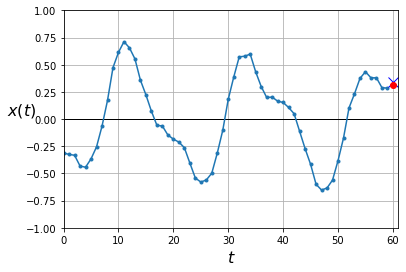

In [14]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :,0], y_valid[0, 0], y_pred[0, 0])
plt.show()

<h4>Deep RNN</h4>
<p>The simple RNN doesn't do better than the linear model, in fact it does quite a bit worse. Next I'll try using a deep RNN with three SimpleRNN layers.</p>

In [15]:
#Making a Deep RNN

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape = [None, 1]),
    keras.layers.SimpleRNN(20, return_sequences = True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss = "mse", optimizer = "adam")
history = model.fit(X_train, y_train, epochs = 20, validation_data = (X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0179 - val_loss: 0.0045
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 5/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 6/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 8/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 9/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 10/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0027 - val_lo

In [16]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0025


0.0025297102984040976

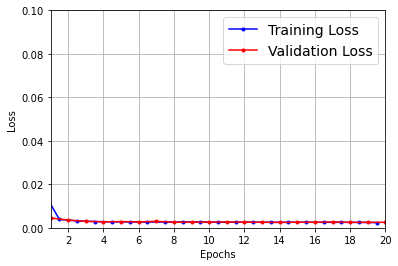

In [17]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

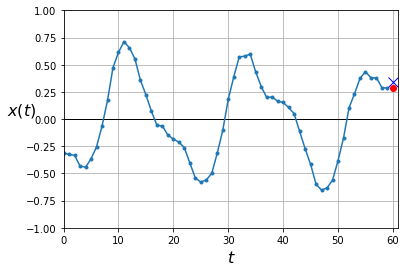

In [18]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :,0], y_valid[0, 0], y_pred[0, 0])
plt.show()

<h2>Forecasting several steps ahead</h2>
<p>The deep RNN did indeed outperform the linear model. Where RNN will really start to shine is with predicting several time steps ahead.</p>

In [19]:
#For plotting multiple timesteps ahead
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Prediction", markersize = 10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize = 14)

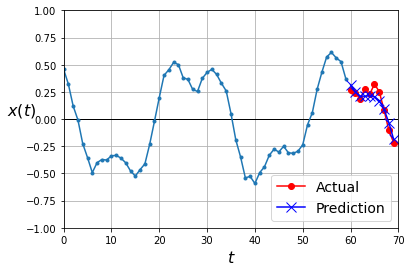

In [20]:
np.random.seed(42)
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis = 1) #concatenate predictions to what we already know
    
Y_pred = X[:, n_steps:]
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [22]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0025


0.0025297102984040976

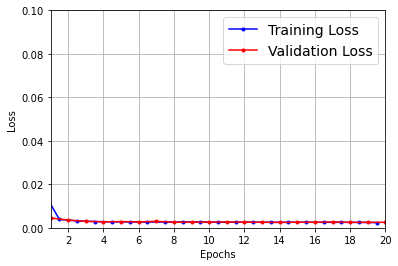

In [23]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [24]:
#Previous was still using Deep RNN, now make one that forecasts ahead at every time step. Ie,
#the Deep RNN used timesteps 0-49 to predict 50-59, but now we want to predict 1-10 and timestep
#0, and 2-11 at timestep 1, etc.
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 60
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

#Need a small function for getting loss at last time step
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0467 - last_time_step_mse: 0.0354 - val_loss: 0.0378 - val_last_time_step_mse: 0.0265
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0367 - last_time_step_mse: 0.0263 - val_loss: 0.0338 - val_last_time_step_mse: 0.0245
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0326 - last_time_step_mse: 0.0235 - val_loss: 0.0284 - val_last_time_step_mse: 0.0190
Epoch 4/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0291 - last_time_step_mse: 0.0199 - val_loss: 0.0302 - val_last_time_step_mse: 0.0232
Epoch 5/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0273 - last_time_step_mse: 0.0184 - val_loss: 0.0242 - val_last_time_step_mse: 0.0150
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0249 - last_time_step_mse: 0.0154 - val_loss: 0.0247 - val_last_time_step_mse: 0.0154
Epoch 7/20
219/219 [==

In [25]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0162 - last_time_step_mse: 0.0062


[0.016219818964600563, 0.0062285978347063065]

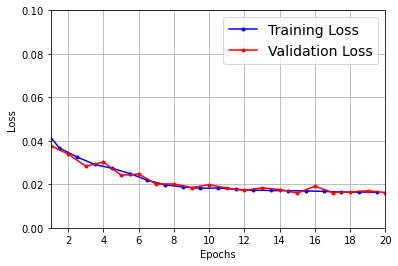

In [26]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

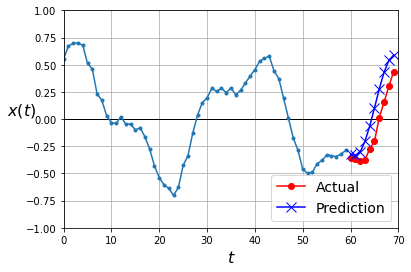

In [27]:
series = generate_time_series(1, 60 + 10)
X_new, Y_new = series[:, :60, :], series[:, 60:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [28]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0162 - last_time_step_mse: 0.0062


[0.016219818964600563, 0.0062285978347063065]

<h4>Deep RNN w/Batch Norm </h4>
<p>Batch Normalization can't be used as efficiently with RNNs as with something like a deep feedforward net, but I just want to try and see what happens when I add Batch Normalization layers between the recurrent layers. </p>

In [29]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 17ms/step - loss: 0.1361 - last_time_step_mse: 0.1184 - val_loss: 0.0694 - val_last_time_step_mse: 0.0614
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0467 - last_time_step_mse: 0.0369 - val_loss: 0.0446 - val_last_time_step_mse: 0.0357
Epoch 3/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0420 - last_time_step_mse: 0.0332 - val_loss: 0.0405 - val_last_time_step_mse: 0.0324
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0392 - last_time_step_mse: 0.0308 - val_loss: 0.0380 - val_last_time_step_mse: 0.0299
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0372 - last_time_step_mse: 0.0288 - val_loss: 0.0368 - val_last_time_step_mse: 0.0284
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0355 - last_time_step_mse: 0.0270 - val_loss: 0.0357 - val_last_time_step_mse: 0.0279
Epoch 7/20
219/219 [==

In [30]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0244 - last_time_step_mse: 0.0141


[0.02444380708038807, 0.014137610793113708]

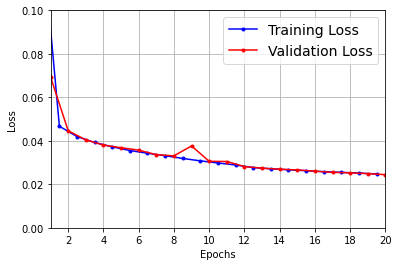

In [31]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

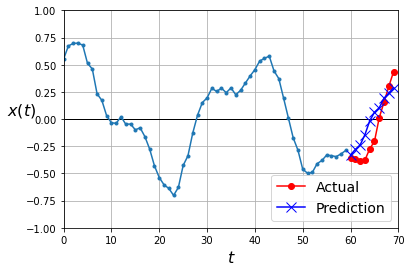

In [32]:
#series = generate_time_series(1, 60 + 10)
X_new, Y_new = series[:, :60, :], series[:, 60:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

<h4>Deep RNN w/ Layer Norm</h4>
<p>Layer Normalization is similar to Batch Normalization, except it normalizes across the features dimension instead of the batch dimension. One of the major advantages is that Layer Normalization behaves the same way during training and testing (BN doesn't), and it doesn't need exponential moving averages to estimate feature statistics across instances in the trainng set. If this was a more complicated task, Layer Normalization would do much better at dealing the unstable gradients than would batch normalization.</p>

In [33]:
from tensorflow.keras.layers import LayerNormalization

In [34]:
class LN_RNN_Cell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
        
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [35]:
model = keras.models.Sequential([
    keras.layers.RNN(LN_RNN_Cell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LN_RNN_Cell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 9s 39ms/step - loss: 0.1978 - last_time_step_mse: 0.1794 - val_loss: 0.0907 - val_last_time_step_mse: 0.0865
Epoch 2/20
219/219 [==============================] - 11s 48ms/step - loss: 0.0673 - last_time_step_mse: 0.0559 - val_loss: 0.0573 - val_last_time_step_mse: 0.0452
Epoch 3/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0533 - last_time_step_mse: 0.0414 - val_loss: 0.0499 - val_last_time_step_mse: 0.0380
Epoch 4/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0466 - last_time_step_mse: 0.0349 - val_loss: 0.0433 - val_last_time_step_mse: 0.0323
Epoch 5/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0415 - last_time_step_mse: 0.0307 - val_loss: 0.0411 - val_last_time_step_mse: 0.0334
Epoch 6/20
219/219 [==============================] - 8s 37ms/step - loss: 0.0386 - last_time_step_mse: 0.0294 - val_loss: 0.0370 - val_last_time_step_mse: 0.0276
Epoch 7/20
219/219 [=

In [36]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 12ms/step - loss: 0.0272 - last_time_step_mse: 0.0165


[0.027216361835598946, 0.016472745686769485]

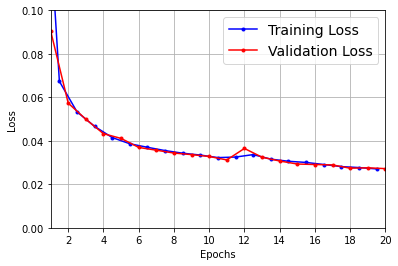

In [37]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

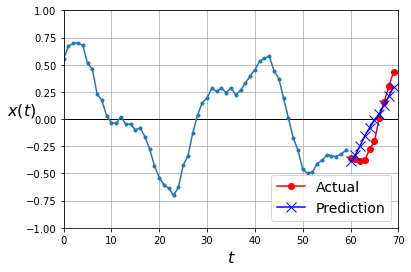

In [38]:
X_new, Y_new = series[:, :60, :], series[:, 60:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

<h4>LSTMs</h4>

In [39]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0735 - last_time_step_mse: 0.0582 - val_loss: 0.0529 - val_last_time_step_mse: 0.0315
Epoch 2/20
219/219 [==============================] - 8s 34ms/step - loss: 0.0453 - last_time_step_mse: 0.0245 - val_loss: 0.0392 - val_last_time_step_mse: 0.0188
Epoch 3/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0350 - last_time_step_mse: 0.0155 - val_loss: 0.0324 - val_last_time_step_mse: 0.0138
Epoch 4/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0309 - last_time_step_mse: 0.0132 - val_loss: 0.0293 - val_last_time_step_mse: 0.0123
Epoch 5/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0287 - last_time_step_mse: 0.0122 - val_loss: 0.0280 - val_last_time_step_mse: 0.0123
Epoch 6/20
219/219 [==============================] - 8s 36ms/step - loss: 0.0272 - last_time_step_mse: 0.0113 - val_loss: 0.0263 - val_last_time_step_mse: 0.0109
Epoch 7/20
219/219 [==

In [40]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 8ms/step - loss: 0.0204 - last_time_step_mse: 0.0071


[0.0204189233481884, 0.0070727514103055]

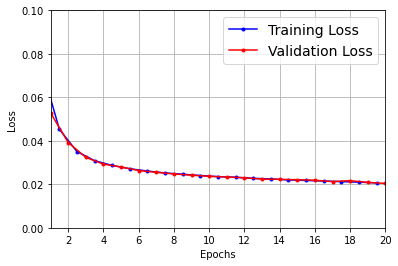

In [41]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

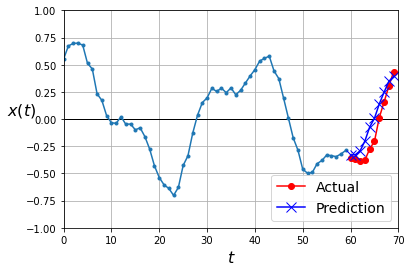

In [42]:
X_new, Y_new = series[:, :60, :], series[:, 60:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

<h4>GRUs</h4>

In [43]:
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 9s 43ms/step - loss: 0.0739 - last_time_step_mse: 0.0648 - val_loss: 0.0505 - val_last_time_step_mse: 0.0386
Epoch 2/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0448 - last_time_step_mse: 0.0340 - val_loss: 0.0406 - val_last_time_step_mse: 0.0292
Epoch 3/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0386 - last_time_step_mse: 0.0271 - val_loss: 0.0363 - val_last_time_step_mse: 0.0242
Epoch 4/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0349 - last_time_step_mse: 0.0231 - val_loss: 0.0322 - val_last_time_step_mse: 0.0197
Epoch 5/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0304 - last_time_step_mse: 0.0182 - val_loss: 0.0284 - val_last_time_step_mse: 0.0151
Epoch 6/20
219/219 [==============================] - 8s 39ms/step - loss: 0.0272 - last_time_step_mse: 0.0140 - val_loss: 0.0273 - val_last_time_step_mse: 0.0160
Epoch 7/20
219/219 [==

In [44]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0192 - last_time_step_mse: 0.0063


[0.019172102212905884, 0.0063428427092731]

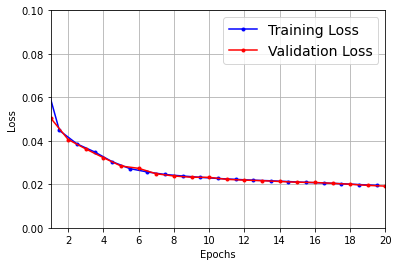

In [45]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

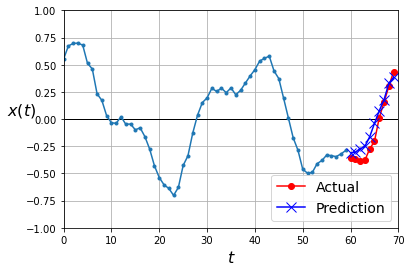

In [46]:
X_new, Y_new = series[:, :60, :], series[:, 60:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()